## Imports and Functions

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom
import numpy
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
from tqdm import tqdm
from scipy.ndimage import rotate

def match_colorbar(ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-5 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = numpy.zeros(img.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    print('Fitted',a,b,c)
    #for k in range(n):
    #    new[y[k], x[k]] = img[ y[k], x[k]] - ( a*x[k] + b*y[k] + c )
    return new, a,b,c

def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def get_scan_step(oversampling,pixel_size,wavelength,distance):
    return wavelength*distance/(oversampling*pixel_size)

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def get_positions(scan_step,size_x,size_y):

    x_positions = np.arange(0,size_x,scan_step)
    y_positions = np.arange(0,size_y,scan_step)

    error = 0.05
    error2 = error
    
    x_pos = x_positions + np.random.normal(scale=error*scan_step,size=x_positions.shape)
    y_pos = y_positions + np.random.normal(scale=error*scan_step,size=y_positions.shape)

    x_pos_error = x_positions + np.random.normal(scale=error2*scan_step,size=x_positions.shape)
    y_pos_error = y_positions + np.random.normal(scale=error2*scan_step,size=y_positions.shape)

    return y_pos,x_pos, y_pos_error,x_pos_error

def set_object_size(x_pos,y_pos,obj_pxl_size,probe_size):
    gap = 10
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))//obj_pxl_size),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))//obj_pxl_size))


def calculate_diffraction_pattern(idx,obj,probe,wavelength,distance,obj_pxl):
    y,x = idx
    wavefront_box = probe*obj[y:y+probe.shape[0],x:x+probe.shape[1]]
    """ Calculate Difpad """ 
    DP = np.abs(propagate_beam(wavefront_box, (obj_pxl,wavelength,distance)))**2
    return DP

def save_angles_file_CAT_standard():
    for i, angle_number in enumerate(range(tomogram.shape[0])): 
        filename = str(angle_number).zfill(4)+f"_complex_phantom_001.txt"
        line = f"Ry: {angles[i]}\tPiezoB2\tPiezoB3\tPiezoB1\t"
        # print(line)
        with open(os.path.join(path,filename), 'w') as f:
            f.write(line)
            
def save_positions_file_CAT_standard(x,y,path,filename):
    # print(x.shape,y.shape)
    line = f"Ry: {0}\tPiezoB2\tPiezoB3\tPiezoB1\t"
    f = open(os.path.join(path,'positions',f"{filename}_001.txt"), 'w')
    f.write(line)
    columns = np.c_[y,x]
    for i in range(columns.shape[0]):
        f.write(f"\n{columns[i,0]}\t{columns[i,1]}")
    f.close()

import h5py 
def create_hdf_file(matrix,path,filename):
    difpads = np.ones((10,5,3))
    hdf_file = h5py.File(os.path.join(path,'scans',f'{filename}_001.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=matrix)
    hdf_file.close()
    
def get_difpads(frame,probe,distance,energy,probe_pxl,real_space_shape,filename,path,oversampling=3):
    
    speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

    wavelength = planck * speed_of_light / energy # meters

    obj_pxl = get_object_pixel(probe.shape[0],probe_pxl,wavelength, distance) # energy keV; distance meters

    scan_step = get_scan_step(oversampling,probe_pxl,wavelength,distance)
    size_y, size_x = obj_pxl*real_space_shape[0], obj_pxl*real_space_shape[1]
    y_pos, x_pos, y_pos_error,x_pos_error = get_positions(scan_step,size_x,size_y)

    """ Save positions file """
    save_positions_file_CAT_standard(x_pos,y_pos,path,filename)
    
    obj_recon_size = set_object_size(x_pos,y_pos,obj_pxl,probe.shape)
    obj = np.zeros(obj_recon_size,dtype=complex)
    obj[probe.shape[0]:probe.shape[0]+frame.shape[0],probe.shape[1]:probe.shape[1]+frame.shape[1]] = frame

    x_pos_pxl = [np.int(x) for x in np.round((x_pos-np.min(x_pos))/obj_pxl)]
    y_pos_pxl = [np.int(y) for y in np.round((y_pos-np.min(y_pos))/obj_pxl)]

    Ymesh, Xmesh = np.meshgrid(y_pos_pxl,x_pos_pxl)

    """ Loop through positions """ 
    difpads = np.zeros((Xmesh.flatten().shape[0],1,probe.shape[0],probe.shape[1]))
    counter = 0
    calculate_diffraction_pattern_partial = partial(calculate_diffraction_pattern,obj=obj,probe=probe,wavelength=wavelength,distance=distance,obj_pxl=obj_pxl)
    idx_list = [ [y,x] for y, x in zip(Ymesh.flatten(),Xmesh.flatten()) ]
    processes = min(os.cpu_count(),32)
    # print(f'Using {processes} parallel processes')
    with ProcessPoolExecutor(max_workers=processes) as executor:
        # results = list(tqdm(executor.map(calculate_diffraction_pattern_partial,idx_list),total=len(idx_list)))
        results = executor.map(calculate_diffraction_pattern_partial,idx_list)
        for counter, result in enumerate(results):
            difpads[counter,0,:,:] = result

    return difpads

def get_projection(angle,magnitude,phase):
    return np.sum(np.abs(rotate(magnitude,angle,reshape=False,axes=(1,0)))*np.exp(1j*rotate(phase,angle,reshape=False,axes=(1,0))),axis=0)

def save_hdf_masks(path,shape):
    path = os.path.join(path,'images')
    
    dbeam = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'dbeam.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=dbeam)
    hdf_file.close()
    
    empty = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'empty.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=empty)
    hdf_file.close()
    
    flat = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'flat.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=flat)
    hdf_file.close()
    
    mask = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'mask.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=mask)
    hdf_file.close()
    return 0

# Phantom

In [2]:
path="/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
N = 250 # size of Donut matrix 
nproc  = 100 # n of cores to create Donut phantom
energy = 7  #Kev
distance = 1 #meter
probe_pxl = 1.25156e-6
rescaling_factor = 16 # rescaling factor
probe_pxl = rescaling_factor*probe_pxl

mdata = {"/entry/beamline/experiment": {"distance": distance*1e3, "energy": energy},
         "/entry/beamline/detector": {"pimega": {"exposure time": 10.0, "pixel size": probe_pxl}}}

import json
json.dump(mdata,open(os.path.join(path,"mdata.json"), "w"))

(250, 250, 200)

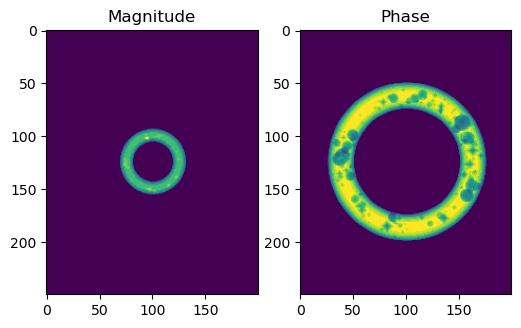

In [3]:
if 0:
    params = { 'HowMany': 3,
               'radius': 0.02,
               'Rtorus': 0.2,
               'rtorus': 0.05}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    magnitude = phantom1 + phantom2

    params = { 'HowMany': 10,
               'radius': 0.07,
               'Rtorus': 0.5,
               'rtorus': 0.1}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    phase = phantom1 + phantom2
    
    phantom = magnitude*np.exp(1j*phase)

    phantom = np.swapaxes(phantom,1,0)
    phantom = phantom[:,:,0:200]
    phantom = np.roll(phantom,-24,axis=2)
    
    np.save(os.path.join(path,'complex_phantom.npy'),phantom)
else:
    phantom = np.load(os.path.join(path,'complex_phantom.npy'))
    
magnitude = np.abs(phantom)
phase = np.angle(phantom)
    
figure, ax = plt.subplots(1,2,dpi=100)
ax[0].imshow(np.sum(magnitude,axis=0)), ax[0].set_title('Magnitude')
ax[1].imshow(np.sum(phase,axis=0)), ax[1].set_title('Phase')

phantom.shape

## Rotate and get projections 

In [4]:
angles = np.linspace(0,180,2*N)
dtheta = angles[1]-angles[0]


get_projection_partial = partial(get_projection,magnitude=magnitude,phase=phase)

if 0:
    sinogram = np.zeros((angles.shape[0],phantom.shape[1],phantom.shape[2]),dtype=complex)
    processes = min(os.cpu_count(),32)
    print(f'Using {processes} parallel processes')
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = list(tqdm(executor.map(get_projection_partial,angles),total=len(angles)))
        for counter, result in enumerate(results):
            if counter % 100 == 0: print('Populating results matrix...',counter)
            sinogram[counter,:,:] = result
    np.save(os.path.join(path,'complex_sinogram.npy'),sinogram)
else:
    sinogram = np.load(os.path.join(path,'complex_sinogram.npy'))
sinogram.shape

(500, 250, 200)

## Probe and Diffraction Patterns

In [ ]:
if 0:
    """ Realistic Probe """

    probe = np.load('probe_at_focus_1.25156micros_pixel.npy')
    print("Probe shape", probe.shape)
    probe.resize((probe.shape[0]//rescaling_factor,probe.shape[1]//rescaling_factor)) 
else:
    """ Round probe """
    probe = np.ones((50,50))
    xprobe = np.linspace(0,probe.shape[0]-1,probe.shape[0])
    xprobe -= probe.shape[0]//2
    Y,X = np.meshgrid(xprobe,xprobe)
    probe = np.where(X**2+Y**2<=20**2,1,0)
    print("Probe shape", probe.shape)

real_space_shape = (int(phantom.shape[0]+2*probe.shape[0]),int(phantom.shape[1]+2*probe.shape[1]))

save_hdf_masks(path,probe.shape)

""" Loop through all frames"""
for i in range(sinogram.shape[0]):
    if i%10==0: print(f"Creating dataset {i}/{sinogram.shape[0]}")
    filename = str(i).zfill(4)+f"_complex_phantom"
    difpads = get_difpads(sinogram[i],probe,distance,energy,probe_pxl,real_space_shape,filename,path,oversampling=3)

    """ Save to hdf file """
    # create_hdf_file(difpads,path,filename)

    difpads = np.swapaxes(difpads,0,1)
    np.save(os.path.join(path,"difpads",f'{filename}_001.hdf5.npy'),difpads)

Probe shape (50, 50)
Creating dataset 0/500
Creating dataset 10/500
Creating dataset 20/500
Creating dataset 30/500
Creating dataset 40/500
Creating dataset 50/500
Creating dataset 60/500
Creating dataset 70/500
Creating dataset 80/500
Creating dataset 90/500
Creating dataset 100/500
Creating dataset 110/500
Creating dataset 120/500
Creating dataset 130/500
Creating dataset 140/500
Creating dataset 150/500
Creating dataset 160/500
Creating dataset 170/500
Creating dataset 180/500
Creating dataset 190/500
Creating dataset 200/500
Creating dataset 210/500
Creating dataset 220/500
Creating dataset 230/500
Creating dataset 240/500
Creating dataset 250/500
Creating dataset 260/500
Creating dataset 270/500
Creating dataset 280/500
Creating dataset 290/500
Creating dataset 300/500
Creating dataset 310/500
Creating dataset 320/500
Creating dataset 330/500
Creating dataset 340/500
Creating dataset 350/500
Creating dataset 360/500
Creating dataset 370/500
Creating dataset 380/500
Creating datase

In [33]:
path = '/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/model'

# import sscCdi
files, _ = sscCdi.misc.list_files_in_folder(path,look_for_extension=".npy")

for file in files:
    data = np.load(file)
    print(data.shape)
    data = np.swapaxes(data,0,1)
    print(data.shape)
    np.save(file,data)

(250, 250, 200)
(250, 250, 200)
(250, 500, 200)
(500, 250, 200)
(800, 800)
(800, 800)
